In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime 
import seaborn as sns

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [2]:
#start database session

engine = create_engine("sqlite:///hawaii.sqlite")
session = Session(engine)

In [3]:
#retrieve table objects

Base = automap_base()
Base.prepare(engine, reflect=True)

In [4]:
#confirm that table classes exist in Base
Base.classes.keys()

['measurements', 'stations']

In [5]:
#create table objects
Measurements = Base.classes.measurements
Stations = Base.classes.stations

### Precipitation Analysis

In [6]:
#query database for precipitation data from the last year

rows = session.query(Measurements.date, Measurements.prcp).filter(Measurements.date > '2016-08-23').all()

#turn queried data into lists
date, precip = zip(*rows)

In [7]:
#create DF out of queried data
data_DF = pd.DataFrame({'date':list(date),'prcp':list(precip)})

#convert date column to datetime data type. This is done for the plot.
data_DF['date'] = data_DF['date'].astype('datetime64[D]')

#set date as index
data_DF = data_DF.set_index('date')

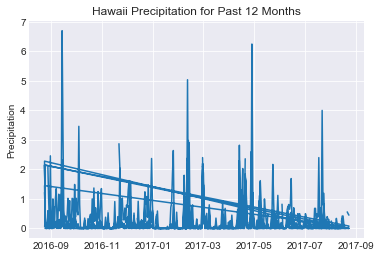

In [8]:
#plot precipitation data for the last year
sns.set_style("darkgrid")
plt.plot(data_DF.index, data_DF['prcp'])
plt.title("Hawaii Precipitation for Past 12 Months")
plt.ylabel('Precipitation')
plt.savefig('precipitation')
plt.show()

prcp_stats = data_DF['prcp'].describe()


In [9]:
#Display precip stats for the last year
print(prcp_stats)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


### Station Analysis

In [10]:
#Total number of stations
session.query(Stations).count()

9

In [11]:
#This shows which station had the most temperature measurements in descending order
session.query(Measurements.station, func.count(Measurements.station)).group_by(Measurements.station)\
.order_by(desc(func.count(Measurements.station))).all() 


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [12]:
#This code queries sqlite for all of the prcp measurements and then removes NaN values from prcp

rows = session.query(Measurements.station, Measurements.prcp).all()

station, precip = zip(*rows)

station_DF = pd.DataFrame({'station':list(station),'prcp':list(precip)})
station_DF = station_DF.dropna()

In [13]:
#This is the order of most active stations when we only count complete measurements(temperature and percipitation).
# Station USC00519281 is the most active for both definitions of activity.
station_DF = station_DF.dropna()
station_DF.groupby(['station']).count().sort_values('prcp', ascending = False)

,prcp
station,
USC00519281,2772
USC00513117,2696
USC00519397,2685
USC00519523,2572
USC00516128,2484
USC00514830,1937
USC00511918,1932
USC00517948,683
USC00518838,342


In [14]:
#Queries last 12 months of temp observations and groups by station

rows = session.query(Measurements.date, Measurements.station, Measurements.tobs)\
    .filter(Measurements.date > '2016-08-23').all()

date, station, tobs = zip(*rows)

data_DF = pd.DataFrame({'date':list(date),'station':list(station),'tobs':list(tobs)})

data_DF[['station', 'tobs']].groupby(['station']).count().sort_values('tobs',ascending = False)

,tobs
station,
USC00519397,360
USC00519281,351
USC00516128,348
USC00513117,342
USC00519523,336
USC00514830,304
USC00517948,182


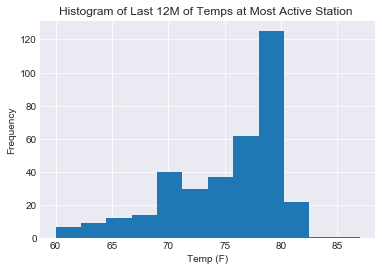

In [15]:
#plot histogram of last 12 months of temp observations for station USC00519397

plt.hist(data_DF.loc[data_DF['station'] =='USC00519397','tobs'], bins =12)
plt.title("Histogram of Last 12M of Temps at Most Active Station ")
plt.ylabel("Frequency")
plt.xlabel("Temp (F)")
plt.savefig("temp_hist.png")
plt.show()

### Temperature Analysis

In [16]:
#define calc_temps function

def calc_temps(start_date, end_date):
    
    #queries for temps in date range
    rows = session.query(Measurements.date, Measurements.tobs).filter(Measurements.date > '{}'.format(start_date))\
            .filter(Measurements.date < '{}'.format(end_date)).all()
    
    #create dataframe from queried data
    date, temp = zip(*rows)

    temp_DF = pd.DataFrame({'date':list(date),'temp':list(temp)})
    
    #find mean, min, max of temp data
    Mean = temp_DF['temp'].mean()
    Min = temp_DF['temp'].min()
    Max = temp_DF['temp'].max()

    Temp = {'Mean': Mean, 'Min': Min,'Max': Max}

    return Temp


In [17]:
#show the mean, max, and min temp of period last year during my vacation time
trip_temps = calc_temps('2017-06-22', '2017-07-02')
trip_temps

{'Max': 82, 'Mean': 77.0925925925926, 'Min': 71}

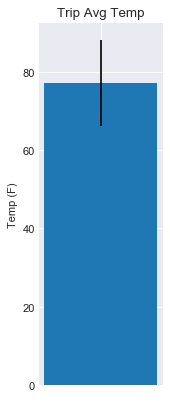

In [18]:
#bar plot of trip_temps
plt.figure(num=None, figsize=(2, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar(0,[trip_temps['Mean']], yerr =(trip_temps['Max']- trip_temps['Min']), tick_label=[' '])
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.savefig("Trip_Temp.png")
plt.show()